In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("numeric_heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Is Data Balanced?

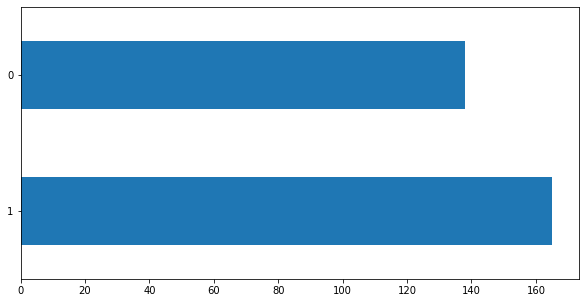

In [4]:
# #Data is Balance
data = df["target"].value_counts()
ax = data.plot.barh(figsize=(10, 5))

In [13]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)


(303, 13)
(303,)


In [14]:
# Splt Data to Train and Test
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(x_train.shape)
print(x_test.shape)

(227, 13)
(76, 13)


# Apply Decision Tree with Default Parameter and Overfitting
As can be seen the criterion of DecisionTreeClassifier can be "gini" or "entropy".

In [15]:
clf = tree.DecisionTreeClassifier(random_state=0,criterion='entropy')
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

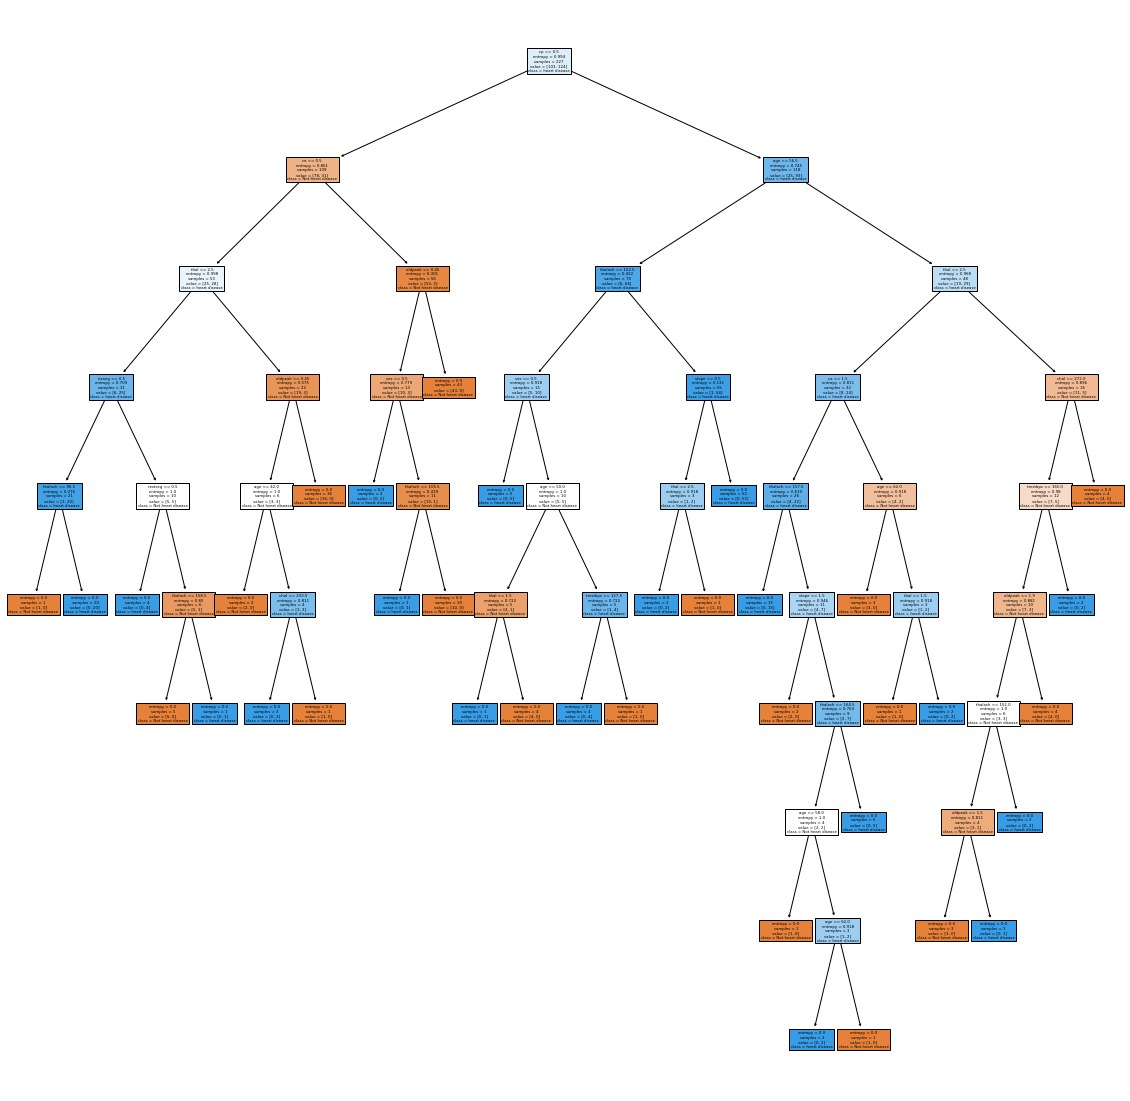

In [16]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

This tree has very bog size and it shows it is overfitting.

# Confusion Metrics for Train and Test With Decision tree Default Parameters 

In [17]:
# Confusion Metircs
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    

Train score 1.0
Test score 0.7368421052631579
Train Confusion matrix


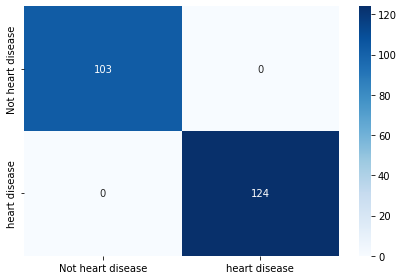

Test Confusion matrix


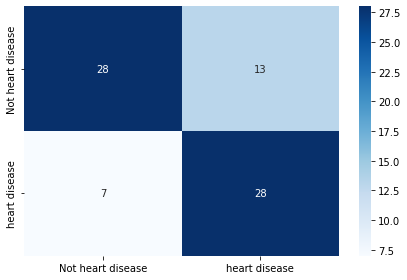

In [18]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

# Avoid Overfitting
## 1)Pre-pruning: 
Early stopping or pre-pruning which stops the growth of a decision tree at an early stage. It generates a tree with fewer branches. We can limit parameters like max_depth , min_samples etc.
An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performance on test data. criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain. as follows:


In [19]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2], 'criterion':["gini","entropy"]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 0.947136563876652
Test score 0.75
Train Confusion matrix


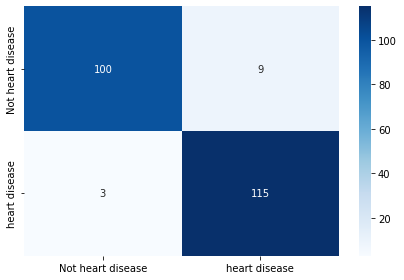

Test Confusion matrix


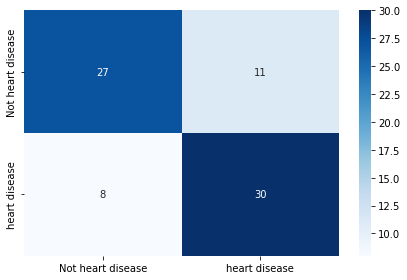

In [20]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

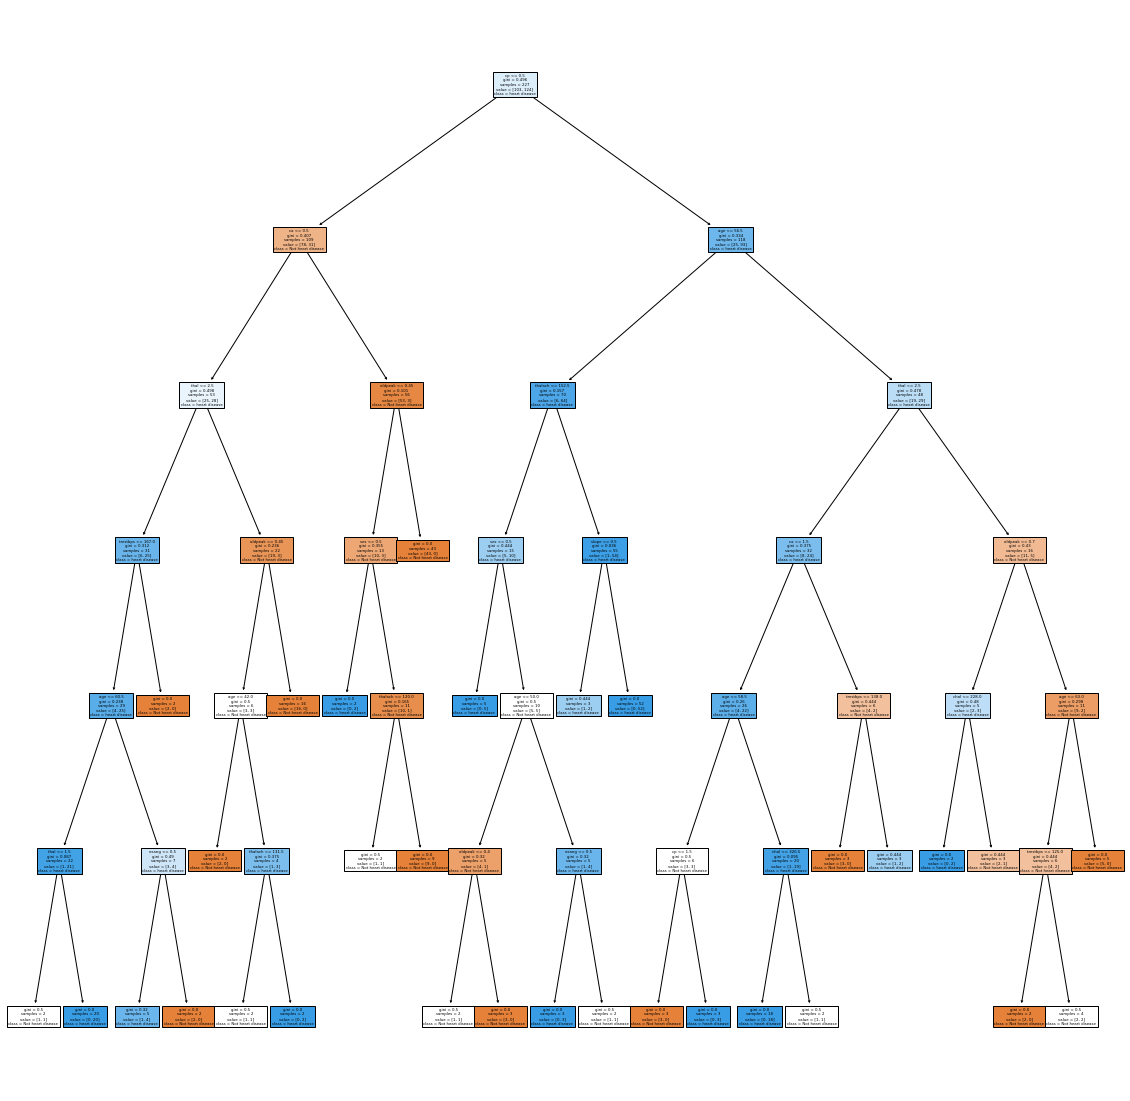

In [21]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

## Result after Preprunning: 
As you can see in the above output, the size of tree is reduced compared to the size before training and training accuracy is 89% and the test accuracy is 75%. The training score is lower than the previous training accuracy. This shows the improvement when tree is pruned, considering overfitting. But still there is still scope of improvement. So, we do post pruning.

# 2) Post pruning techniques: 
post-pruning that is generating a tree in full and then removing parts of it. This is most effective way to avoid overfitting is to use post pruning methods like cost complexity pruning. This helps to improve test accuracy and get a better model. 
### Cost complexity pruning is all about finding the right parameter for alpha. Greater values of alpha increase the number of nodes pruned. 


In [22]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00396476 0.00418502 0.00432519 0.00528634 0.00566013
 0.00587372 0.00589207 0.00660793 0.00704846 0.00704846 0.00704846
 0.00763583 0.00803536 0.00961153 0.01031333 0.01072518 0.01129561
 0.01166641 0.01225052 0.01798825 0.02412783 0.05090686 0.05406743
 0.12667349]


In [23]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

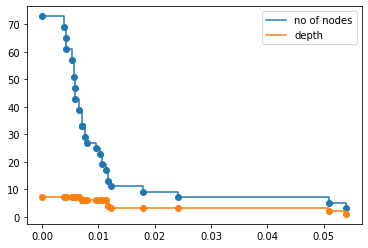

In [24]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

Output above shows as alpha increases no of nodes and depth decreases.

## What is the Best Alpha in Post Prunning?

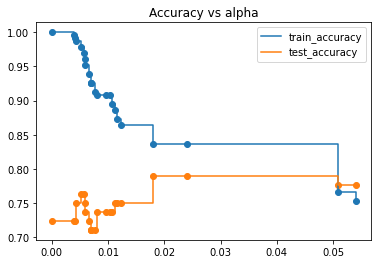

In [25]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

By looking at the plot, we can decide the optimal alpha value that mitigates overfitting in our decision tree model is alpha = 0.020

# Decision Tree and Performance Metrics After Setting the Best Alpha of Post Prunning:
This is after finding the Best alpha, we have the following results:

Train score 0.8370044052863436
Test score 0.7894736842105263
Train Confusion matrix


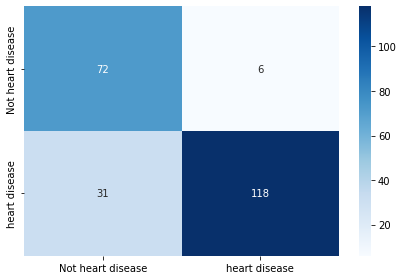

Test Confusion matrix


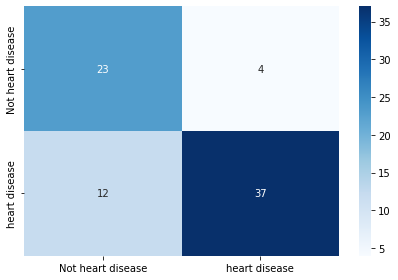

In [26]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

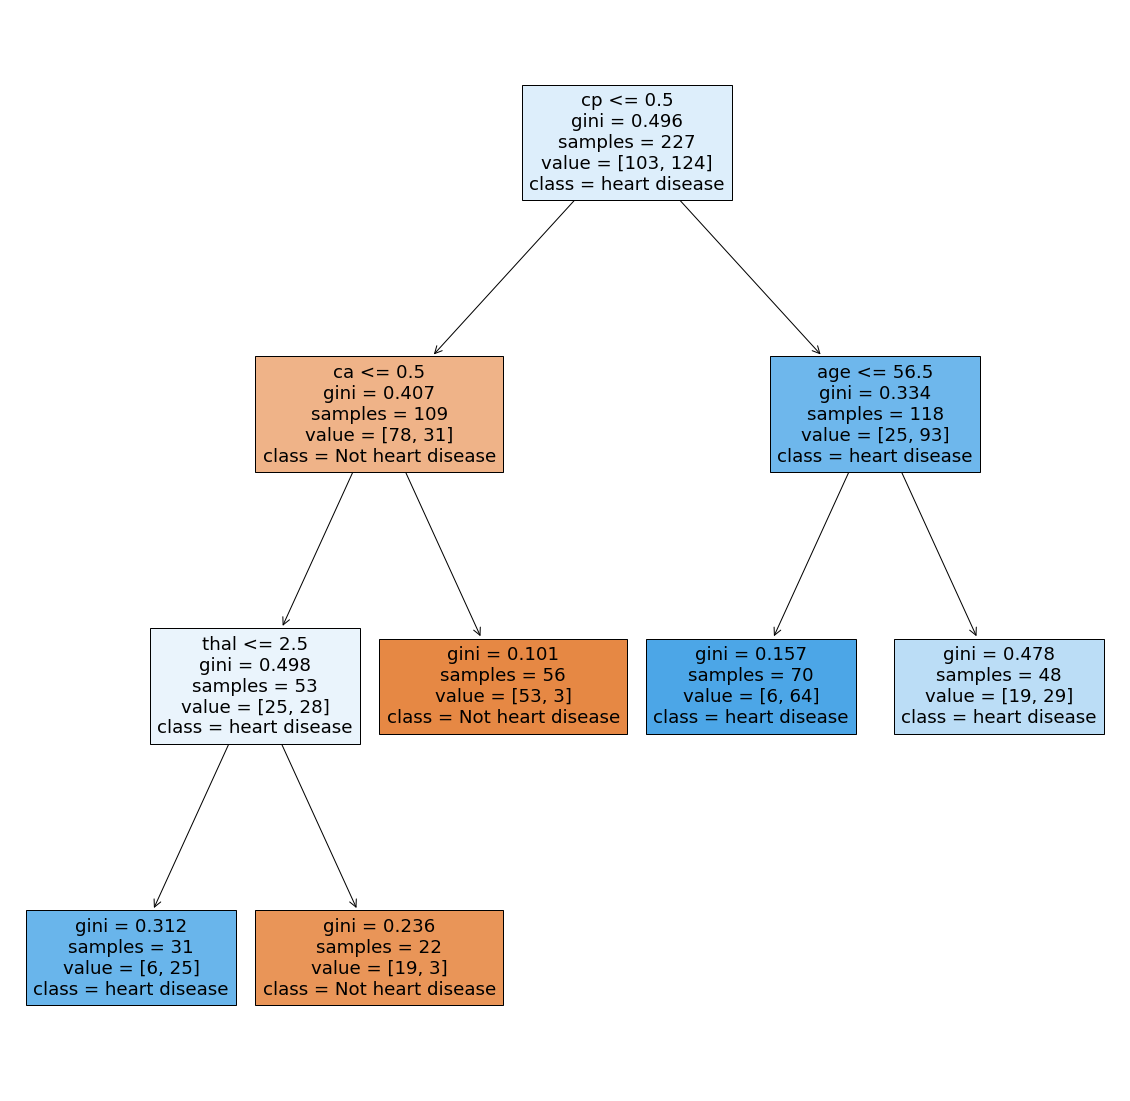

In [27]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()

## Result After Post Pruning:
We can see that the train score is getting lower and the accuracy of test score improves. This shows that there is not thet much gap between train and test scores. Also, size of decision tree significantly got reduced. Also postpruning is much efficient than prepruning. In this kernel we have used accuracy as metricas data was balanced. 